<a href="https://colab.research.google.com/github/rato42/linear_regression/blob/unstable-yeah-sure/CLASSBASED_new_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [42]:
import sys

# Detect Colab environment
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import drive, auth
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaIoBaseDownload
    !pip install pwlf

    import pwlf

    auth.authenticate_user()
    drive.mount("/content/drive")
else:
    import pwlf
    from oauth2client.service_account import ServiceAccountCredentials

    print("Running outside Colab (VS Code/local)")

try:
    import gspread
except ModuleNotFoundError:
    if IN_COLAB and "google.colab" in str(get_ipython()):
        %pip install gspread
    import gspread

from gspread_dataframe import set_with_dataframe

Running outside Colab (VS Code/local)


In [43]:

import os
from scipy import fftpack
import time

import math
import scipy.stats as stats
import pandas as pd
import numpy as np

from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.cov_struct import Autoregressive

from scipy.stats import chi2
from sklearn.linear_model import Ridge
import statsmodels.api as sm
import copy
from statsmodels.tsa.stattools import acf

from openpyxl import load_workbook
from openpyxl.styles import Alignment

from scipy.stats import linregress, ttest_ind, ttest_rel, ttest_1samp
import matplotlib.pyplot as plt
import re
from openpyxl.drawing.image import Image
from matplotlib.font_manager import FontProperties
from io import BytesIO
import statsmodels.formula.api as smf
import statsmodels.api as sm

import numpy as np
import plotly.graph_objects as go


from datetime import datetime, timedelta

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from statsmodels.genmod.families import Gamma
from dateutil.relativedelta import relativedelta

from sklearn import set_config
set_config(display="diagram")

import logging
from typing import Dict, Any

import io

# LOAD --- data from gsheet if colab or local


In [44]:
dados_brutos = None
output_wksheet = None

input_path = "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0"
output_path = "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0"

local_input_path = (
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input.csv" ### poa
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total_RS.xlsx" ### rs
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total_RS_percentual.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_IR_1000_poa.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_IR_1000_brasil.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\regions_IR_1000.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\raw_regions_joined.xlsx"
    "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_2023_fixedf10.xlsx"
)

output_wksheet = None

if IN_COLAB:
    import gspread
    from google.auth import default

    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    workbook = gc.open_by_url(input_path)
    worksheets = workbook.worksheets()
    output_wksheet = gc.open_by_url(output_path)
    dados_brutos = worksheets[0].get_all_values()
else:
    try:
        dados_brutos = pd.read_csv(local_input_path, header=None).values.tolist()
    except:
        dados_brutos = pd.read_excel(local_input_path, header=None).values.tolist()

# Diagnosticos Relatório

In [45]:
"""
📋 Seção: Diagnóstico do Modelo e Justificativas Metodológicas

Para a modelagem da variável de interesse (taxa de incidência de atendimentos em saúde mental), foi utilizado um modelo de regressão do tipo GLM com família NegativeBinomial e função de ligação logarítmica, apropriado para dados de contagem com potencial overdispersão. Adicionalmente, os erros padrão foram estimados com correção de heterocedasticidade e autocorrelação via covariância tipo HAC (Newey-West).
Avaliação diagnóstica

Foram aplicados testes residuais com o objetivo de verificar a presença de violações aos pressupostos clássicos de regressão e avaliar a adequação dos métodos corretivos utilizados:

    Heterocedasticidade (teste de Breusch-Pagan): identificada em nível marginal (p = 0.034), indicando variância dos resíduos não constante. No entanto, os erros padrão do modelo foram estimados com correção robusta (cov_type='HAC'), o que assegura a validade da inferência estatística mesmo diante desse problema.

    Overdispersão (teste qui-quadrado com resíduos de Pearson): ausente (Pearson χ² / df ≈ 1.00), sugerindo que o uso do modelo NegativeBinomial foi suficiente para ajustar a variância excedente dos dados de contagem. Esta evidência reforça a escolha do modelo como apropriada.

    Autocorrelação (estatísticas Durbin-Watson = 1.42 e Ljung-Box p = 0.016): foi identificada autocorrelação residual de baixa a moderada. No entanto, a inferência dos coeficientes já foi ajustada para esse tipo de dependência temporal com a adoção da covariância robusta do tipo HAC.

Interpretação

A presença residual de heterocedasticidade e autocorrelação é esperada em séries temporais aplicadas à saúde pública, especialmente em análises por regiões agregadas. No entanto, com a utilização das correções mencionadas (modelo NegativeBinomial e erros tipo HAC), garante-se que:

    Os valores dos coeficientes estimados são consistentes;

    Os intervalos de confiança e p-valores são confiáveis, mesmo diante das violações detectadas nos resíduos.

Assim, os resultados apresentados podem ser considerados robustos e interpretáveis do ponto de vista epidemiológico.
"""

"\n📋 Seção: Diagnóstico do Modelo e Justificativas Metodológicas\n\nPara a modelagem da variável de interesse (taxa de incidência de atendimentos em saúde mental), foi utilizado um modelo de regressão do tipo GLM com família NegativeBinomial e função de ligação logarítmica, apropriado para dados de contagem com potencial overdispersão. Adicionalmente, os erros padrão foram estimados com correção de heterocedasticidade e autocorrelação via covariância tipo HAC (Newey-West).\nAvaliação diagnóstica\n\nForam aplicados testes residuais com o objetivo de verificar a presença de violações aos pressupostos clássicos de regressão e avaliar a adequação dos métodos corretivos utilizados:\n\n    Heterocedasticidade (teste de Breusch-Pagan): identificada em nível marginal (p = 0.034), indicando variância dos resíduos não constante. No entanto, os erros padrão do modelo foram estimados com correção robusta (cov_type='HAC'), o que assegura a validade da inferência estatística mesmo diante desse probl

In [46]:
'''
Structured Prompt for Analysis

Study Context
I am conducting an Interrupted Time Series (ITS) analysis to evaluate the impact of the COVID-19 pandemic on mental health visit rates (per 1,000 total visits). The goal is to model changes in mental health visit rates before, during, and after the pandemic, adjusting for seasonality and underlying trends.
Data Structure

    Outcome: Count of mental health visits (integer).

    Predictors:

        Time variables (e.g., periodo, Pandemia_Step, Pandemia_Trend, PosPandemia_Step, PosPandemia_Trend).

        Seasonal controls (Fourier terms: cos1, sin1).

    Offset: log(total_visits / 1000) to model rates (visits per 1,000 total visits).

    Sample: 108 monthly observations.

Key Challenges

    Severe Overdispersion: Initial Poisson models show extreme overdispersion (Pearson χ²/df ≈ 456).

    Rate Modeling: Properly handling the offset to convert counts into rates.

Models Considered

    Poisson GLM with Offset

        Pros: Theoretically appropriate for count rates.

        Cons: Fails to address overdispersion, leading to underestimated SEs and inflated significance.

    Negative Binomial (NB) GLM with Offset

        Pros: Explicitly models overdispersion via dispersion parameter α.

        Cons: Requires careful interpretation of α in rate contexts.

    Quasi-Poisson with Manual SE Adjustment

        Pros: Adjusts SEs post-hoc using dispersion factor φ = Pearson χ² / df.

        Cons: Ad-hoc implementation in Python (no built-in support), lacks likelihood-based inference.

Key Results
Model    Dispersion Handling    Significant Findings
Poisson (naive)    None (ϕ=1 assumed)    Overly optimistic p-values (all significant)
Negative Binomial    Explicit (α ≈ 0.5)    Most effects non-significant post-adjustment
Quasi-Poisson (HC1)    Post-hoc SE scaling    Intermediate significance (e.g., PosPandemia_Trend p=0.015)
Question

Which model is most appropriate for valid inference?

    Does the Negative Binomial model’s use of an offset and dispersion parameter α create interpretational conflicts for rates?

    Is Quasi-Poisson with robust SEs (HC1) sufficient despite lacking a formal likelihood?

    Should I prioritize Poisson with robust SEs or switch to Negative Binomial?

Additional Context:

    Implementation is in Python (statsmodels).

    The final model must support hypothesis testing (e.g., step/trend changes during pandemic).

What’s the best approach?
'''

'\nStructured Prompt for Analysis\n\nStudy Context\nI am conducting an Interrupted Time Series (ITS) analysis to evaluate the impact of the COVID-19 pandemic on mental health visit rates (per 1,000 total visits). The goal is to model changes in mental health visit rates before, during, and after the pandemic, adjusting for seasonality and underlying trends.\nData Structure\n\n    Outcome: Count of mental health visits (integer).\n\n    Predictors:\n\n        Time variables (e.g., periodo, Pandemia_Step, Pandemia_Trend, PosPandemia_Step, PosPandemia_Trend).\n\n        Seasonal controls (Fourier terms: cos1, sin1).\n\n    Offset: log(total_visits / 1000) to model rates (visits per 1,000 total visits).\n\n    Sample: 108 monthly observations.\n\nKey Challenges\n\n    Severe Overdispersion: Initial Poisson models show extreme overdispersion (Pearson χ²/df ≈ 456).\n\n    Rate Modeling: Properly handling the offset to convert counts into rates.\n\nModels Considered\n\n    Poisson GLM with Of

In [47]:
def build_model_formula(dependant_var, independant_var=False, dummy_names=[]):
    """
    Builds the regression formula dynamically.

    Parameters:
    -----------
    dependant_var : str
        The dependent variable (Y).
    independant_var : str or bool
        The independent variable (X). If False, it will be excluded.
    dummy_names : list
        List of dummy variable names to include in the formula.

    Returns:
    --------
    str
        The regression formula.
    """
    base_model_formula = f"{dependant_var} ~ "
    if independant_var:
        base_model_formula += f"{independant_var} + "

    # Add dummy variables (including Fourier terms if present)
    model_formula = base_model_formula
    if dummy_names:
        for i, dummy in enumerate(dummy_names):
            model_formula += dummy
            if i != len(dummy_names) - 1:  # Add '+' if not the last element
                model_formula += " + "

    return model_formula.strip(" + "), base_model_formula.strip(" + ")


def build_dummy_names(dummies_args, include_month_dummies, include_quarter_dummies, include_fourier_terms=False, n_harmonics=1, period_f=12):
    """
    Builds the list of dummy variable names dynamically.

    Parameters:
    -----------
    dummies_args : dict
        Dictionary of dummy variable configurations.
    include_month_dummies : bool
        Whether to include month dummies.
    include_quarter_dummies : bool
        Whether to include quarter dummies.
    include_fourier_terms : bool
        Whether to include Fourier terms for seasonality.
    n_harmonics : int
        Number of Fourier harmonics to include.

    Returns:
    --------
    list
        List of dummy variable names.
    """
    dummy_names = []

    # Add dummy variables from dummies_args
    for dummy_name in dummies_args.keys():
        dummy_names.append(dummy_name)

    # Add Fourier terms if enabled
    if include_fourier_terms:
        for k in range(1, n_harmonics + 1):
            dummy_names.append(f"cos{k}_{period_f}")
            dummy_names.append(f"sin{k}_{period_f}")

    # Add month dummies if enabled
    if include_month_dummies:
        for i in range(1, 12):
            dummy_names.append("month_" + str(i + 1))

    # Add quarter dummies if enabled
    if include_quarter_dummies:
        for i in range(1, 4):
            dummy_names.append("quarter_" + str(i + 1))

    return dummy_names


# ARGS --- Define Args


In [48]:
### ARGS

LOCAL_OUTPUT_PATH = "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\output\\output.xlsx"

MODEL_DEF = 'GLM'
RAW_ATD_VAR = 'mental_health_visits'
RAW_TOTAL_ATD_VAR = 'total_atd'
IR_VAR = 'IR'
DATE_NAME = "date"
GROUP_COL_NAME = "regiao"
INDEPENDENT_VAR = "periodo"  ### X
DEPENDENT_VAR = RAW_ATD_VAR if (MODEL_DEF == "GEE" or MODEL_DEF == "GLM") else IR_VAR

IR_SCALE = 1000

######### DUMMIES ##########

INCLUDE_SEMI_ANUAL_FOURIER = False
INCLUDE_FOURIER_TERMS = True
N_HARMONICS = 1
FOURIER_PERIOD = 12
INCLUDE_MONTH_DUMMIES = False
INCLUDE_QUARTER_DUMMIES = False

PULSE_START_DATE = "2020-04-01"
PULSE_END_DATE = "2020-05-01"
PANDEMIA_START_DATE = "2020-04-01"
PANDEMIA_END_DATE = "2022-03-01" 
POS_PANDEMIA_START_DATE = "2022-04-01"
END_DATE = "2024-12-01"

PANDEMIA_EXCLUDE_RANGES = []
POS_PANDEMIA_EXCLUDE_RANGES = []

TREND_KEEP_PERIOD_INDEX = False  ### se True, o modelo vai manter o index do periodo, se False, o modelo vai usar o index do dataframe original (sem os dummies)

DUMMY_ARGS =        {
        #'Pandemia_Pulse': {"start_date": PULSE_START_DATE, "end_date": PULSE_END_DATE, 'exclude_ranges': PANDEMIA_EXCLUDE_RANGES},
        'Pandemia_Step': {"start_date": PANDEMIA_START_DATE, "end_date": PANDEMIA_END_DATE, 'exclude_ranges': PANDEMIA_EXCLUDE_RANGES,},
        'Pandemia_Trend' : {"start_date": PANDEMIA_START_DATE, "end_date": PANDEMIA_END_DATE,'exclude_ranges': PANDEMIA_EXCLUDE_RANGES, 'add_time_trend': True, 'keep_period_index': TREND_KEEP_PERIOD_INDEX},
        'PosPandemia_Step': {"start_date": POS_PANDEMIA_START_DATE, "end_date": END_DATE,'exclude_ranges': POS_PANDEMIA_EXCLUDE_RANGES, 'plot':False, 'step': True,},
        'PosPandemia_Trend' : {"start_date": POS_PANDEMIA_START_DATE, "end_date": END_DATE,'exclude_ranges': POS_PANDEMIA_EXCLUDE_RANGES, 'plot': True, 'add_time_trend': True, 'keep_period_index': TREND_KEEP_PERIOD_INDEX, 'step': False},
        }

DUMMY_NAMES = build_dummy_names(
          DUMMY_ARGS,
          INCLUDE_MONTH_DUMMIES,
          INCLUDE_QUARTER_DUMMIES,
          include_fourier_terms=INCLUDE_FOURIER_TERMS,
          n_harmonics=N_HARMONICS,
          period_f=FOURIER_PERIOD,
          )
##############################
MAXLAGS = 3

PREPROCESSOR_ARGS = {
    'DateRange': {
        'year_start': 2018,
        'year_end': 2023,
        'month_start': 1,    # Optional (defaults to 1)
        'month_end': 12,#3,   #12, # 
        'day_start': 1,      # Optional (defaults to 1)
        'day_end': 31        # Optional (defaults to 31)
    },
    'FrequencyDateGroup': 'M',
    'DummyArgs': DUMMY_ARGS,
    'melt_total_atd': True,
    'ExtractIR': True,
}


MODEL_FORMULA, BASE_MODEL_FORMULA = build_model_formula(DEPENDENT_VAR,
                                                        INDEPENDENT_VAR,
                                                        dummy_names = DUMMY_NAMES,
                                                        )
if INCLUDE_SEMI_ANUAL_FOURIER:
    MODEL_FORMULA += '+' + 'cos1_6' + '+' + 'sin1_6'

In [49]:
MODEL_FORMULA

'mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend + PosPandemia_Step + PosPandemia_Trend + cos1_12 + sin1_12'

# Define Preprocessors


In [50]:
def BuildDataDF(data):
    string_dates = data[0][1:]  # Store original string dates

    # Converter as strings de datas em objetos datetime
    #date_list = [datetime.strptime(date, "%d/%m/%Y") for date in string_dates]
    date_list = [
    date if isinstance(date, datetime) else datetime.strptime(date, "%d/%m/%Y")
    for date in string_dates
    ]

    # Extrair os nomes das variáveis
    variavel = [row[0] for row in data[1:]]

    # Extrair os dados (sem agrupamento)
    dados = [row[1:] for row in data[1:]]
    dados = np.array(dados, dtype=float)  # Converter para tipo object para evitar warning

    # Criar o DataFrame with DatetimeIndex
    df = pd.DataFrame(data=dados, index=variavel, columns=pd.DatetimeIndex(date_list))

    return df


class MeltTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        var_name=GROUP_COL_NAME,
        value_name=RAW_ATD_VAR,
        date_name=DATE_NAME,
        y_name=INDEPENDENT_VAR,
        perform_IR=False,
        total_suffix="_total",
        total_column_name=RAW_TOTAL_ATD_VAR,
    ):
        self.var_name = var_name
        self.value_name = value_name
        self.date_name = date_name
        self.y_name = y_name
        self.perform_IR = perform_IR
        self.total_suffix = total_suffix
        self.total_column_name = total_column_name

    def fit(self, X, y=None):
        # Nothing to learn, so just return self
        return self

    def transform(self, X):
        # Separate rows with the `_total` suffix
        if self.perform_IR:
            reserved_rows = X[X.index.str.endswith(self.total_suffix)]
            remaining_rows = X[~X.index.str.endswith(self.total_suffix)]

            # Transpose and reset index for the remaining rows
            df_long = remaining_rows.T.reset_index()

            # Rename index to date_name
            df_long = df_long.rename(columns={"index": self.date_name})

            # Melt the DataFrame
            df_long = pd.melt(
                df_long,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.value_name,
            )

            # Sort by category and date
            df_final = df_long.sort_values([self.var_name, self.date_name]).reset_index(
                drop=True
            )

            # Add the `total_atd` column
            reserved_rows = reserved_rows.T.reset_index().rename(columns={"index": self.date_name})
            reserved_rows_long = pd.melt(
                reserved_rows,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.total_column_name,
            )

            # Remove the `_total` suffix from the var_name in reserved_rows_long
            reserved_rows_long[self.var_name] = reserved_rows_long[self.var_name].str.replace(
                self.total_suffix, "", regex=False
            )

            # Merge the `total_atd` column into the final DataFrame
            df_final = df_final.merge(
                reserved_rows_long,
                on=[self.date_name, self.var_name],
                how="left",
            )
        else:
                        # Transpose and reset index for the remaining rows
            df_long = X.T.reset_index()

            # Rename index to date_name
            df_long = df_long.rename(columns={"index": self.date_name})

            # Melt the DataFrame
            df_long = pd.melt(
                df_long,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.value_name,
            )

            # Sort by category and date
            df_final = df_long.sort_values([self.var_name, self.date_name]).reset_index(
                drop=True
            )


        return df_final

class PeriodIndexAdder(BaseEstimator, TransformerMixin):
    def __init__(self, group_col=GROUP_COL_NAME, new_col=INDEPENDENT_VAR):
        self.group_col = group_col
        self.new_col = new_col
        self.period_date_mapping = {}  # Dictionary to store period-date equivalences

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_col] = X.groupby(self.group_col).cumcount() + 1

        #Store the mapping of periods to dates
        self.period_date_mapping = dict(zip(X[DATE_NAME], X[self.new_col]))
        #for group, group_data in X.groupby(self.group_col):
        #    self.period_date_mapping[group] = dict(zip(group_data[DATE_NAME], group_data[self.new_col]))

        return X

class DataFrameSorter(BaseEstimator, TransformerMixin):
    """
    Sorts a DataFrame by a specified column.

    Parameters:
    -----------
    sort_by : str
        Name of the column to sort by.
    ascending : bool, default=True
        Whether to sort in ascending order.
    """

    def __init__(self, sort_by, ascending=True):
        self.sort_by = sort_by
        self.ascending = ascending

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.sort_by not in X.columns:
            raise ValueError(f"Column '{self.sort_by}' not found in DataFrame.")
        return X.sort_values(by=self.sort_by, ascending=self.ascending).reset_index(drop=True)

class MonthlyDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds dummy variables for each month to control for seasonality, leaving December as the baseline.

    Parameters:
    -----------
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, date_column=DATE_NAME):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])  # Ensure dates are in datetime format

        # Extract month from the date column
        X['month'] = X[self.date_column].dt.month

        # Create dummy variables for each month, excluding December as the baseline
        month_dummies = pd.get_dummies(X['month'], prefix="month", drop_first=True).astype(int)



        # Concatenate the dummy variables with the original DataFrame
        X = pd.concat([X, month_dummies], axis=1)

        # Drop the temporary 'month' column
        X.drop(columns=['month'], inplace=True)

        return X

class QuarterlyDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds dummy variables for each quarter to control for seasonality, leaving Q4 as the baseline.

    Parameters:
    -----------
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, date_column=DATE_NAME):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])  # Ensure dates are in datetime format

        # Extract quarter from the date column
        X['quarter'] = X[self.date_column].dt.quarter

        # Create dummy variables for each quarter, excluding Q4 as the baseline
        quarter_dummies = pd.get_dummies(X['quarter'], prefix="quarter", drop_first=True).astype(int)

        # Concatenate the dummy variables with the original DataFrame
        X = pd.concat([X, quarter_dummies], axis=1)

        # Drop the temporary 'quarter' column
        X.drop(columns=['quarter'], inplace=True)

        return X

class MultiDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds multiple dummy variables based on date ranges or custom conditions.
    Allows each dummy to be binary or a local time trend via its own config.

    Parameters:
    -----------
    dummy_config : dict
        Dictionary defining dummy variables. Example:
        {
            'Pandemia': {
                'start_date': '2020-01-01',
                'end_date': '2020-12-31',
                'add_time_trend': True,
                'exclude_ranges': [
                    ('2020-04-01', '2020-05-01'),
                    ('2020-07-01', '2020-08-01')
                ]  # Optional
            }
        }
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, dummy_config, date_column=DATE_NAME):
        self.dummy_config = dummy_config
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        X = X.sort_values(self.date_column).reset_index(drop=True)

        for dummy_name, config in self.dummy_config.items():
            start_date = pd.to_datetime(config.get("start_date"))
            end_date = pd.to_datetime(config.get("end_date"))
            use_trend = config.get("add_time_trend", False)
            keep_index = config.get("keep_period_index", False)
            exclude_ranges = config.get("exclude_ranges", [])  # List of ranges to exclude

            if not start_date:
                raise ValueError(f"Missing 'start_date' for dummy '{dummy_name}'.")

            # Create the initial mask for the date range
            if end_date is not None:
                mask = (X[self.date_column] >= start_date) & (X[self.date_column] <= end_date)
            else:
                mask = X[self.date_column] >= start_date

            # Exclude multiple ranges within the period
            for excl_start, excl_end in exclude_ranges:
                excl_start = pd.to_datetime(excl_start)
                excl_end = pd.to_datetime(excl_end)
                mask &= ~((X[self.date_column] >= excl_start) & (X[self.date_column] <= excl_end))

            # Apply trend or binary dummy logic
            if use_trend:
                if keep_index:
                    # Global period multiplied by the dummy
                    X[dummy_name] = 0
                    X.loc[mask, dummy_name] = X.loc[mask, INDEPENDENT_VAR]
                else:
                    start_periodo = X.loc[mask, INDEPENDENT_VAR].min()
                    X[dummy_name] = 0
                    X.loc[mask, dummy_name] = (X.loc[mask, INDEPENDENT_VAR] - start_periodo + 1).clip(lower=0)
            else:
                X[dummy_name] = mask.astype(int)

        return X

class FrequencyGroupingTransformer(BaseEstimator, TransformerMixin):
    """
    ## only datetime supported groupings
    Transformer for grouping data by standard datetime frequencies.

    This transformer takes a DataFrame with datetime columns and groups
    the data by a specified frequency (e.g., 'Q' for quarterly, 'M' for monthly).

    ARGS:
        frequency (str): The frequency to group by. Defaults to 'Q' (quarterly).
                        Supported frequencies are those accepted by pd.Grouper (e.g., 'Q', 'M', 'Y').
    """

    def __init__(self, frequency="Q"):  # Default to quarterly grouping
        self.frequency = frequency

    def fit(self, X, y=None):
        """
        This transformer does not require fitting.

        ARGS:
            X (pd.DataFrame): The input DataFrame.
            y (Any, optional): Ignored. Defaults to None.

        Returns:
            self: Returns the transformer instance.
        """
        return self

    def transform(self, X):
        """
        Groups the data by the specified frequency and sums the values.

        ARGS:
            X (pd.DataFrame): The input DataFrame with datetime columns.

        Returns:
            pd.DataFrame: The grouped DataFrame with summed values.
                          Columns are datetime objects representing the end of each group.
        """
        if self.frequency == None or self.frequency == 'M':
            return X
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")



        # Convert columns to datetime if they are not already
        if not isinstance(X.columns[0], pd.Timestamp):
            X.columns = pd.to_datetime(X.columns, errors="coerce")

        # Group by the specified frequency using pd.Grouper
        grouped_df = X.T.groupby(pd.Grouper(freq=self.frequency)).sum().T

        return grouped_df







In [51]:
class MovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col=GROUP_COL_NAME, date_col=DATE_NAME, value_col=DEPENDENT_VAR, window=3, prefix='ma', center=False):
        """
        window: tamanho da janela
        prefix: prefixo para o nome da nova coluna
        center: se True, a janela será centralizada
        """
        self.window = window
        self.prefix = prefix
        self.center = center
        self.value_col = value_col
        self.group_col = group_col
        self.date_col = date_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def rolling_mean_by_group(group):
            group = group.sort_values(by=self.date_col)  # Sort by date within group
            new_col = f"{self.prefix}_{self.window}_{self.value_col}"
            group[new_col] = group[self.value_col].rolling(window=self.window, center=self.center, min_periods=1).mean()
            return group

        # Apply the rolling mean and reset the index to preserve the original structure
        X = X.groupby(self.group_col, group_keys=False).apply(rolling_mean_by_group)

        return X

In [52]:
from statsmodels.tsa.deterministic import Fourier

class FourierSeasonalityAdder(BaseEstimator, TransformerMixin):
    def __init__(self, date_column=DATE_NAME, period=12, order=1):
        """
        Parameters:
        -----------
        date_column : str
            Name of the column containing dates (must be datetime).
        period : int
            The period of the seasonality (e.g., 12 for monthly data).
        order : int
            The number of Fourier harmonics to include.
        """
        self.date_column = date_column
        self.period = period
        self.order = order
        self.fourier = Fourier(period=self.period, order=self.order)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ensure the date column is in datetime format
        X[self.date_column] = pd.to_datetime(X[self.date_column])

        # Ensure unique index
        if not X.index.is_unique:
            X = X.reset_index(drop=True)

        # Generate Fourier terms
        fourier_terms = self.fourier.in_sample(X[self.date_column])

        # Rename Fourier columns to use sin1, cos1, etc.
        renamed_columns = {col: f"sin{int(i/2)+1}" if i % 2 else f"cos{int(i/2)+1}"
                           for i, col in enumerate(fourier_terms.columns)}
        fourier_terms.rename(columns=renamed_columns, inplace=True)

        # Concatenate Fourier terms with the original DataFrame
        X = pd.concat([X.reset_index(drop=True), fourier_terms.reset_index(drop=True)], axis=1)

        # Debugging: Check the range of Fourier terms
        for column in fourier_terms.columns:
            min_value = fourier_terms[column].min()
            max_value = fourier_terms[column].max()
            if min_value < -1 or max_value > 1:
                print(f"Warning: {column} is out of range [-1, 1]. Min: {min_value}, Max: {max_value}")
            else:
                print(f"{column} is within the correct range [-1, 1]. Min: {min_value}, Max: {max_value}")

        return X

In [53]:
class DateFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        periodos_inclusivos=None,
        periodos_exclusivos=None,
        date_col=DATE_NAME
    ):
        self.periodos_inclusivos = periodos_inclusivos
        self.periodos_exclusivos = periodos_exclusivos
        self.date_col = date_col

    def get_date_range(self, **kwargs):
        """
        Generates a date range from keyword arguments.
        Expected kwargs: year_start, year_end, month_start, month_end, day_start, day_end
        """
        # Default values
        year_start = kwargs.get('year_start')
        year_end = kwargs.get('year_end', year_start)
        month_start = kwargs.get('month_start', 1)
        month_end = kwargs.get('month_end', 12)
        day_start = kwargs.get('day_start', 1)
        day_end = kwargs.get('day_end', 31)

        if year_start is None:
            raise ValueError("At least year_start must be provided")

        start_date = datetime(year=year_start, month=month_start, day=day_start)
        end_date = datetime(year=year_end, month=month_end, day=day_end)
        
        return pd.date_range(start=start_date, end=end_date, freq="D")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if not pd.api.types.is_datetime64_any_dtype(X[self.date_col]):
            X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")

        if self.periodos_inclusivos:
            valid_dates = self.get_date_range(**self.periodos_inclusivos)
            return X[X[self.date_col].isin(valid_dates)].reset_index(drop=True)

        elif self.periodos_exclusivos:
            invalid_dates = self.get_date_range(**self.periodos_exclusivos)
            return X[~X[self.date_col].isin(invalid_dates)].reset_index(drop=True)

        return X

In [54]:
def adicionar_termos_fourier(df, group_col, date_col, period=12, order=1, test=False, plot =False):
    """
    Adiciona termos de Fourier ao DataFrame para cada grupo e plota os resultados.
    
    Parâmetros:
        df: DataFrame original
        group_col: Nome da coluna de agrupamento
        date_col: Nome da coluna de data
        period: Período da sazonalidade (padrão=12)
        order: Ordem dos termos de Fourier (padrão=1)
    """
    resultados = []
    
    for variable in df[group_col].unique():
        # Filtra e ordena os dados do grupo
        group_data = df[df[group_col] == variable].sort_values(date_col)
        group_data = group_data.reset_index(drop=True)
        
        ## test

        
        y = group_data[DEPENDENT_VAR].values
        y_sem_tendencia = y - np.mean(y)  # Remove o componente DC
        # Ou, para diferenciação (útil em modelos como ARIMA):
        y_diff = np.diff(y, n=1)  # Remove tendência linear
        y = y_diff
        fft_resultado = fftpack.fft(y)
        frequencias = fftpack.fftfreq(len(y), d=1)
        metade = len(y) // 2

                # Extraia os valores numéricos
        frequencias_positivas = frequencias[:metade]
        magnitudes = np.abs(fft_resultado[:metade])
        

        if test:
            n_peaks = 3

            # Identifica os índices dos n_peaks maiores magnitudes
            # argsort ordena; pegamos os últimos n_peaks e invertemos para ordem decrescente
            indices_top = np.argsort(magnitudes)[-n_peaks:][::-1]
            top_freqs  = frequencias_positivas[indices_top]
            top_mags   = magnitudes[indices_top]

            # Imprime os 3 maiores picos
            print(f"Top {n_peaks} picos para variavel {variable}(frequência em ciclos/mês → magnitude):")
            for freq, mag in zip(top_freqs, top_mags):
                print(f"  {freq:.6f} → {mag:.2f}")
            ## Crie uma tabela formatada para copiar e colar
            #print("Frequência (ciclos/mês)\tMagnitude")
            #print("-----------------------\t---------")
            #for freq, mag in zip(frequencias_positivas, magnitudes):
            #    print(f"{freq:.6f}\t\t\t{mag:.2f}")
#
            ## Ou para exportar como CSV
            #np.savetxt('fft_resultados.csv', 
            #   np.column_stack([frequencias_positivas, magnitudes]),
            #   delimiter=',', 
            #   header='Frequencia(ciclos/mes),Magnitude',
            #   comments='',
            #   fmt='%.6f,%.2f')
            #plt.plot(frequencias[:metade], np.abs(fft_resultado[:metade]))
            #plt.title(variable)
            #plt.xlabel('Frequência (ciclos/mês)')
            #plt.ylabel('Magnitude')
            #plt.show()
            #plt.show()





        # Gera termos de Fourier
        t = np.arange(len(group_data))
        fourier_terms = {}
        
        for i in range(1, order + 1):
            fourier_terms[f'sin{i}_{period}'] = np.sin(2 * np.pi * i * t / period)
            fourier_terms[f'cos{i}_{period}'] = np.cos(2 * np.pi * i * t / period)
        
        # Converte para DataFrame e adiciona ao group_data
        fourier_df = pd.DataFrame(fourier_terms)
        group_data = pd.concat([group_data, fourier_df], axis=1)
        resultados.append(group_data)
        
        if plot:
            plt.figure(figsize=(12, 6))
            plt.plot(fourier_df[f'sin{i}_{period}'], label=f'sin{i}_{period}', color='blue')
            plt.plot(fourier_df[f'cos{i}_{period}'], label=f'cos{i}_{period}', color='red')
            plt.title(f'Termos de Fourier - {variable} (Período={period})')
            plt.xlabel('Índice')
            plt.ylabel('Valor')
            plt.legend()
            plt.grid(True)
            plt.show()
    
    # Retorna o DataFrame consolidado com todos os grupos
    return pd.concat(resultados, ignore_index=True)


# EXEC --- Instantiate Pipe and get RegressionDF

In [55]:

pipe = Pipeline(
    [
        ("grouping", FrequencyGroupingTransformer(frequency=PREPROCESSOR_ARGS['FrequencyDateGroup'])),
        ("melt", MeltTransformer(perform_IR=PREPROCESSOR_ARGS['melt_total_atd'])),
        ("date_filter", DateFilterTransformer(periodos_inclusivos=PREPROCESSOR_ARGS['DateRange'])),
        ("period_index_adder", PeriodIndexAdder()),
        ("dummy_adder", MultiDummyAdder(dummy_config=PREPROCESSOR_ARGS['DummyArgs'])),
        ("monthly_dummy_adder", MonthlyDummyAdder()),
        ("quarterly_dummy_adder", QuarterlyDummyAdder()),
        ("sorter", DataFrameSorter(sort_by=GROUP_COL_NAME, ascending=False)),
    ]
)


RawDataDF = BuildDataDF(dados_brutos)
RegressionDF = pipe.fit_transform(RawDataDF)


if PREPROCESSOR_ARGS['ExtractIR']:
    RegressionDF[IR_VAR] =  RegressionDF[RAW_ATD_VAR]/RegressionDF[RAW_TOTAL_ATD_VAR] * IR_SCALE

if RegressionDF[RAW_TOTAL_ATD_VAR] is not None:
    RegressionDF["offset"] = np.log(RegressionDF["total_atd"] / IR_SCALE)

RegressionDF = adicionar_termos_fourier(
    df=RegressionDF,
    group_col=GROUP_COL_NAME,
    date_col=DATE_NAME,
    period=FOURIER_PERIOD,  
    order=N_HARMONICS,
    test = False,
    plot = False     
)

#RegressionDF = adicionar_termos_fourier(
#    df=RegressionDF,
#    group_col=GROUP_COL_NAME,
#    date_col=DATE_NAME,
#    period=6,  # Ajuste conforme sua sazonalidade
#    order=1,     # Número de pares sin/cos
#)
RegressionDF
#NationalDF =RegressionDF[RegressionDF[GROUP_COL_NAME] == 'Brasil'].sort_values(by=DATE_NAME)
#NationalDF
print(RegressionDF)
RegressionDF

           date  regiao  mental_health_visits   total_atd  periodo  \
0    2018-01-01     sul               86601.0   3323595.0        1   
1    2018-02-01     sul               83997.0   3127761.0        2   
2    2018-03-01     sul               95073.0   3799601.0        3   
3    2018-04-01     sul               99755.0   3954977.0        4   
4    2018-05-01     sul               96343.0   3950949.0        5   
...         ...     ...                   ...         ...      ...   
1219 2023-08-01  Brasil             1082764.0  34826560.0       68   
1220 2023-09-01  Brasil              927356.0  28574833.0       69   
1221 2023-10-01  Brasil             1000871.0  31539972.0       70   
1222 2023-11-01  Brasil              939448.0  29912945.0       71   
1223 2023-12-01  Brasil              799763.0  25454786.0       72   

      Pandemia_Step  Pandemia_Trend  PosPandemia_Step  PosPandemia_Trend  \
0                 0               0                 0                  0   
1      

,date,regiao,mental_health_visits,total_atd,periodo,Pandemia_Step,Pandemia_Trend,PosPandemia_Step,PosPandemia_Trend,month_2,...,month_10,month_11,month_12,quarter_2,quarter_3,quarter_4,IR,offset,sin1_12,cos1_12
0,2018-01-01,sul,86601.0,3323595.0,1,0,0,0,0,0,...,0,0,0,0,0,0,26.056424,8.108802,0.000000,1.000000e+00
1,2018-02-01,sul,83997.0,3127761.0,2,0,0,0,0,1,...,0,0,0,0,0,0,26.855313,8.048073,0.500000,8.660254e-01
2,2018-03-01,sul,95073.0,3799601.0,3,0,0,0,0,0,...,0,0,0,0,0,0,25.021838,8.242651,0.866025,5.000000e-01
3,2018-04-01,sul,99755.0,3954977.0,4,0,0,0,0,0,...,0,0,0,1,0,0,25.222650,8.282730,1.000000,6.123234e-17
4,2018-05-01,sul,96343.0,3950949.0,5,0,0,0,0,0,...,0,0,0,1,0,0,24.384774,8.281711,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,2023-08-01,Brasil,1082764.0,34826560.0,68,0,0,1,17,0,...,0,0,0,0,1,0,31.090179,10.458136,-0.500000,-8.660254e-01
1220,2023-09-01,Brasil,927356.0,28574833.0,69,0,0,1,18,0,...,0,0,0,0,1,0,32.453593,10.260282,-0.866025,-5.000000e-01
1221,2023-10-01,Brasil,1000871.0,31539972.0,70,0,0,1,19,0,...,1,0,0,0,0,1,31.733414,10.359011,-1.000000,-3.184701e-15
1222,2023-11-01,Brasil,939448.0,29912945.0,71,0,0,1,20,0,...,0,1,0,0,0,1,31.406069,10.306047,-0.866025,5.000000e-01


# Exploração pressupostos

In [56]:
print("=== Mean-Variance Check by Region ===")
dispersion_check_variable = DEPENDENT_VAR
for region in RegressionDF[GROUP_COL_NAME].unique():
    region_df = RegressionDF[RegressionDF[GROUP_COL_NAME] == region]
    print(f"\nRegion: {region}")
    print(f"Mean: {region_df[dispersion_check_variable].mean():.2f}")
    print(f"Variance: {region_df[dispersion_check_variable].var():.2f}")
    print(f"Variance/Mean Ratio: {region_df[dispersion_check_variable].var()/region_df[dispersion_check_variable].mean():.2f}")

=== Mean-Variance Check by Region ===

Region: sul
Mean: 128664.93
Variance: 1583520774.35
Variance/Mean Ratio: 12307.32

Region: sudeste
Mean: 239853.64
Variance: 8239569583.45
Variance/Mean Ratio: 34352.49

Region: norte
Mean: 20420.56
Variance: 78004986.67
Variance/Mean Ratio: 3819.92

Region: nordeste
Mean: 107802.99
Variance: 2941726944.92
Variance/Mean Ratio: 27287.99

Region: centro_oeste
Mean: 42082.88
Variance: 245246065.10
Variance/Mean Ratio: 5827.69

Region: F99_F99_nao_especificado
Mean: 10906.08
Variance: 14275572.58
Variance/Mean Ratio: 1308.96

Region: F90_F98_comportamento
Mean: 24205.51
Variance: 128748827.32
Variance/Mean Ratio: 5318.99

Region: F80_F89_desenvolvimento
Mean: 32298.46
Variance: 419135273.94
Variance/Mean Ratio: 12976.94

Region: F70_F79_retardado
Mean: 10612.50
Variance: 16515570.37
Variance/Mean Ratio: 1556.24

Region: F60_F69_personalidade
Mean: 4503.56
Variance: 3431260.93
Variance/Mean Ratio: 761.90

Region: F50_F59_fisiologicos
Mean: 16824.86
Var

# Define Group Iterator

In [57]:
def glm_group_iterator(dataframe, group_col = GROUP_COL_NAME, date_col = DATE_NAME, formula = MODEL_FORMULA):
    results = {}
    for variable in dataframe[group_col].unique():
        variable_data = dataframe[dataframe[group_col] == variable].sort_values(by=date_col)
        variable_data = variable_data.reset_index(drop=True)
        offset = variable_data['offset']
        
        model = smf.glm(data =  variable_data,
                         formula = formula,
                           family= sm.families.NegativeBinomial(alpha=1.0),
                             offset = offset)
        result = model.fit(            
            max_iter = 100,
            cov_type= "HAC",  
            cov_kwds= {'maxlags': MAXLAGS}  
            )
        results[variable] = result
        print(f"Results for {variable}:")
        print("AIC:", result.aic)

        bic_manual = -2 * result.llf + (result.df_model + 1) * np.log(result.nobs)
        
        print("BIC recalculado:", bic_manual)
        print(result.summary())
    return results



In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from patsy import dmatrices
import numpy as np

def sarimax_group_iterator_with_offset(
    dataframe,
    count_var="mental_health_visits",
    exposure_var="total_atd",
    group_col=GROUP_COL_NAME,
    date_col=DATE_NAME,
    formula=MODEL_FORMULA,
    arima_order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=True,
    enforce_invertibility=True
):
    results = {}

    for group in dataframe[group_col].unique():
        print(f"\n🔍 Rodando SARIMAX para: {group}")
        df_group = dataframe[dataframe[group_col] == group].sort_values(by=date_col)
        df_group = df_group.reset_index(drop=True)

        # Calcula o offset e adiciona como covariável
        df_group["offset_log_exposure"] = np.log(df_group[exposure_var] / 1000).replace(-np.inf, 0)

        # Atualiza fórmula adicionando offset como covariável
        full_formula = f"{count_var} ~ offset_log_exposure + ({formula.split('~')[1].strip()})"
       

        # Cria y e X
        y, X = dmatrices(full_formula, data=df_group, return_type='dataframe')
        y = y.iloc[:, 0]  # converte para Series

        try:
            model = SARIMAX(
                endog=y,
                exog=X,
                order=arima_order,
                seasonal_order=seasonal_order,
                enforce_stationarity=enforce_stationarity,
                enforce_invertibility=enforce_invertibility
            )
            result = model.fit(disp=False)
            results[group] = result

            print(f"AIC: {result.aic:.2f}")
            bic = -2 * result.llf + result.params.shape[0] * np.log(result.nobs)
            print(f"BIC recalculado: {bic:.2f}")
            print(result.summary())
        except Exception as e:
            print(f"💥 Erro ao ajustar modelo para {group}: {e}")
            results[group] = None

    return results


In [59]:
def estimate_alpha_moments(df, formula, offset_col):
    
    # 1) Ajuste Poisson
    pois = smf.glm(
        formula=formula,
        data=df,
        family=sm.families.Poisson(),
        offset=df[offset_col]
    ).fit()

    # 2) Resíduos e fitted
    y  = df[pois.model.endog_names]
    mu = pois.fittedvalues

    # 3) estimador de moments: (sum[(y-mu)^2 - mu]) / sum(mu^2)
    num = ((y - mu)**2 - mu).sum()
    den = (mu**2).sum()
    alpha_hat = max(num/den, 0.0)
    phi_hat   = pois.pearson_chi2 / pois.df_resid
    return alpha_hat, phi_hat

# Exemplo de uso:
for variable in RegressionDF[GROUP_COL_NAME].unique():
    variable_data = RegressionDF[RegressionDF[GROUP_COL_NAME] == variable].sort_values(by=DATE_NAME)
    variable_data = variable_data.reset_index(drop=True)
    #offset = variable_data['offset']
    alpha_hat, phi_hat = estimate_alpha_moments(variable_data, MODEL_FORMULA, 'offset')
    print(f"{variable}:alpha ≃ {alpha_hat:.4f}, phi ≃ {phi_hat:.2f}")


sul:alpha ≃ 0.0030, phi ≃ 460.92
sudeste:alpha ≃ 0.0022, phi ≃ 648.06
norte:alpha ≃ 0.0039, phi ≃ 114.77
nordeste:alpha ≃ 0.0028, phi ≃ 400.14
centro_oeste:alpha ≃ 0.0047, phi ≃ 231.30
F99_F99_nao_especificado:alpha ≃ 0.0055, phi ≃ 80.52
F90_F98_comportamento:alpha ≃ 0.0041, phi ≃ 127.67
F80_F89_desenvolvimento:alpha ≃ 0.0050, phi ≃ 292.82
F70_F79_retardado:alpha ≃ 0.0036, phi ≃ 50.20
F60_F69_personalidade:alpha ≃ 0.0026, phi ≃ 15.00
F50_F59_fisiologicos:alpha ≃ 0.0019, phi ≃ 38.19
F40_F48_ansiosos:alpha ≃ 0.0025, phi ≃ 770.69
F30_F39_humor:alpha ≃ 0.0023, phi ≃ 385.23
F20_F29_esquizofrenia_etc:alpha ≃ 0.0024, phi ≃ 107.44
F10_F19_uso_substancia:alpha ≃ 0.0027, phi ≃ 36.86
F00_F09_transtornos_organicos:alpha ≃ 0.0024, phi ≃ 70.60
Brasil:alpha ≃ 0.0021, phi ≃ 1409.56


In [60]:
from statsmodels import api as sm
import numpy as np
import statsmodels.formula.api as smf

def glm_nb_two_step(df, group_col, date_col, formula, offset_col='offset', maxlags=MAXLAGS):
    results = {}
    for grp in df[group_col].unique():
        dfg = (
            df[df[group_col] == grp]
            .sort_values(by=date_col)
            .reset_index(drop=True)
        )
        # 1) Estima α e φ
        alpha_hat, phi_hat = estimate_alpha_moments(dfg, formula, offset_col)
        print(f"{grp}: alpha ≃ {alpha_hat:.4f}, phi ≃ {phi_hat:.2f}")

        # 2) Ajusta NB com α fixo
        res = smf.glm(
            formula=formula,
            data=dfg,
            family=sm.families.NegativeBinomial(alpha=alpha_hat),
            offset=dfg[offset_col]
        ).fit(
            max_iter=100,
            cov_type="HAC",
            cov_kwds={"maxlags": maxlags}
        )

        print(f"Results for {grp}:")
        bic_manual = -2 * res.llf + (res.df_model + 1) * np.log(res.nobs)
        
        print(" AIC:", res.aic)
        print("BIC recalculado:", bic_manual)

        print(res.summary())
        results[grp] = res
    return results


# EXEC --- Instantiate Processor and Process

In [61]:
print(np.exp(0.0031))

1.003104809969017


In [62]:
results= glm_nb_two_step(RegressionDF, group_col = GROUP_COL_NAME, date_col = DATE_NAME, formula = MODEL_FORMULA)

sul: alpha ≃ 0.0030, phi ≃ 460.92
Results for sul:
 AIC: 1497.5408053959254
BIC recalculado: 1515.7541343480539
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                   72
Model:                              GLM   Df Residuals:                       64
Model Family:          NegativeBinomial   Df Model:                            7
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -740.77
Date:                  sex, 06 jun 2025   Deviance:                       78.840
Time:                          13:20:50   Pearson chi2:                     76.7
No. Iterations:                       5   Pseudo R-squ. (CS):             0.8673
Covariance Type:                    HAC                                         
                        coef    std err          z      P>|z|      [0.025     

# Defs Analise Descritiva

In [63]:
def resumo_descritivo_completo(df, group_col=GROUP_COL_NAME, atd_var=RAW_ATD_VAR, total_var=RAW_TOTAL_ATD_VAR):
    df = df.copy()

    # Criar variável de proporção mensal
    df['proporcao_mensal'] = df[atd_var] / df[total_var]

    # Máscaras dos períodos
    pre_mask = (df['Pandemia_Step'] == 0) & (df['PosPandemia_Step'] == 0)
    pand_mask = df['Pandemia_Step'] > 0
    pos_mask = df['PosPandemia_Step'] > 0
    total_mask = df[atd_var].notna()  # tudo

    def calc_stats(mask, periodo_nome):
        temp = df[mask].groupby(group_col).agg(
            **{f'Total_{periodo_nome}': (atd_var, 'sum'),
               f'Media_mensal_{periodo_nome}': (atd_var, 'mean'),
               f'Mediana_mensal_{periodo_nome}': (atd_var, 'median'),
               f'Proporcao_media_{periodo_nome}': ('proporcao_mensal', 'mean'),
               f'Proporcao_mediana_{periodo_nome}': ('proporcao_mensal', 'median')}
        ).reset_index()
        return temp

    # Calcular para cada período
    pre = calc_stats(pre_mask, 'Pre')
    pand = calc_stats(pand_mask, 'Pand')
    pos = calc_stats(pos_mask, 'Pos')
    total = calc_stats(total_mask, 'Total')

    # Merge dos períodos
    df_final = total.merge(pre, on=group_col, how='outer')
    df_final = df_final.merge(pand, on=group_col, how='outer')
    df_final = df_final.merge(pos, on=group_col, how='outer')

    return df_final.round(4)


In [64]:
def resumo_formato_mendeley(df, group_col=GROUP_COL_NAME, atd_var=RAW_ATD_VAR, total_var=RAW_TOTAL_ATD_VAR):
    df = df.copy()

    # Criar proporção mensal
    df['proporcao_mensal'] = df[atd_var] / df[total_var]

    # Máscaras por período
    pre_mask = (df['Pandemia_Step'] == 0) & (df['PosPandemia_Step'] == 0)
    pand_mask = df['Pandemia_Step'] > 0
    pos_mask = df['PosPandemia_Step'] > 0
    total_mask = df[atd_var].notna()

    # Total do período completo
    total_df = df[total_mask].groupby(group_col).agg(
        Total_mental_visits=(atd_var, 'sum'),
        Total_geral=(total_var, 'sum')
    ).reset_index()
    total_df['Proporcao_total'] = total_df['Total_mental_visits'] / total_df['Total_geral']

    # Função para estatísticas de mediana e IQR como medida composta
    def get_median_and_iqr_stats(mask, periodo_nome):
        temp = df[mask].groupby(group_col).agg(
            **{
                f'Mediana_mensal_{periodo_nome}': (atd_var, 'median'),
                f'Mediana_proporcao_{periodo_nome}': ('proporcao_mensal', 'median'),
                f'IQR_mensal_{periodo_nome}': (atd_var, lambda x: x.quantile(0.75) - x.quantile(0.25))  # IQR = Q3 - Q1
            }
        ).reset_index()
        
        # Criar uma coluna composta de Mediana (IQR) para atendimentos apenas
        temp[f'Mediana_com_IQR_{periodo_nome}'] = temp.apply(
            lambda row: f"{row[f'Mediana_mensal_{periodo_nome}']} ({row[f'IQR_mensal_{periodo_nome}']})", axis=1
        )

        return temp

    # Gerar tabelas por período
    print(df[pre_mask].groupby(group_col)[atd_var].describe())
    pre = get_median_and_iqr_stats(pre_mask, 'Pre')
    pand = get_median_and_iqr_stats(pand_mask, 'Pand')
    pos = get_median_and_iqr_stats(pos_mask, 'Pos')

    # Merge geral
    result = total_df.merge(pre, on=group_col, how='outer')
    result = result.merge(pand, on=group_col, how='outer')
    result = result.merge(pos, on=group_col, how='outer')

    return result#.round(3)


In [65]:
def mediana_proporcao_anual_por_grupo(df, group_col=GROUP_COL_NAME, atd_var=RAW_ATD_VAR, total_var=RAW_TOTAL_ATD_VAR):
    df = df.copy()

    # Criar a proporção mensal
    df['proporcao_mensal'] = df[atd_var] / df[total_var] *1000

    # Extrair o ano da data
    df['Ano'] = df['date'].dt.year

    # Calcular a mediana da proporção mensal por grupo e ano
    resumo = (
        df.groupby([group_col, 'Ano'])['proporcao_mensal']
        .median()
        .reset_index()
        .pivot(index=group_col, columns='Ano', values='proporcao_mensal')
    )

    return resumo.round(5)


def mediana_anual_por_grupo(df, group_col=GROUP_COL_NAME, atd_var=RAW_ATD_VAR):
    df = df.copy()

    # Extrair o ano da data
    df['Ano'] = df['date'].dt.year

    # Calcular a mediana mensal por grupo e ano
    resumo = (
        df.groupby([group_col, 'Ano'])[atd_var]
        .median()
        .reset_index()
        .pivot(index=group_col, columns='Ano', values=atd_var)
    )

    return resumo.round(2)



In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from matplotlib.colors import LogNorm

def prepare_summary(df, group_col, atd_var, total_var, series_name_map=None):
    df = df.copy()
    df['proporcao_mensal'] = df[atd_var] / df[total_var] * 1000
    df['Ano'] = df['date'].dt.year
    grouped = df.groupby([group_col, 'Ano'])['proporcao_mensal']
    median = grouped.median().reset_index().pivot(index=group_col, columns='Ano', values='proporcao_mensal')
    iqr = grouped.quantile(0.75) - grouped.quantile(0.25)
    iqr = iqr.reset_index().pivot(index=group_col, columns='Ano', values='proporcao_mensal')
    # Rename series if mapping provided
    if series_name_map is not None:
        median = median.rename(index=series_name_map)
        iqr = iqr.rename(index=series_name_map)
    return median.round(2), iqr.round(2)


def plot_heatmap_with_iqr(
    median_df,
    iqr_df,
    titulo="Proporção mensal por 1000 atendimentos",
    clr_map=None,
    norm=None,
    y_label=None,
    figsize=(10, 6),
    iqr_font_size = 7,
    median_font_size = 10
):
    # Define colormap
    if clr_map is None:
        clr_map = LinearSegmentedColormap.from_list(
            "AzulNeutroVerde",
            ["#f7fbff", "#c6dbef", "#66c2a4", "#238b45"]
        )
    # Default normalization: linear scale between min and max
    if norm is None:
        from matplotlib.colors import Normalize
        norm = Normalize(vmin=median_df.min().min(), vmax=median_df.max().max())
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    # Plot base heatmap without annotations
    sns.heatmap(
        median_df,
        annot=False,
        cmap=clr_map,
        norm=norm,
        linewidths=0.5,
        cbar=False,  # Remove colorbar for clarity
        ax=ax
    )
    # Annotate each cell with median and IQR
    for i, row in enumerate(median_df.index):
        for j, col in enumerate(median_df.columns):
            med = median_df.loc[row, col]
            iqr = iqr_df.loc[row, col]
            # Median text
            ax.text(
                j + 0.5, i + 0.45,
                f"{med:.2f}",
                ha='center', va='center', fontsize=median_font_size, color='black'
            )
            # IQR text below in smaller font
            ax.text(
                j + 0.5, i + 0.75,
                f"({iqr:.2f})",
                ha='center', va='center', fontsize=iqr_font_size, color='black'
            )
    # Titles and labels
    ax.set_title(titulo)
    # Set custom y-axis label if provided
    ax.set_ylabel(y_label if y_label is not None else (median_df.index.name or ""))
    ax.set_xlabel(median_df.columns.name or "Ano")
    ax.set_yticklabels(median_df.index, rotation=0)
    ax.set_xticklabels(median_df.columns, rotation=45)
    plt.tight_layout()
    plt.show()


# Run Analise Descritiva

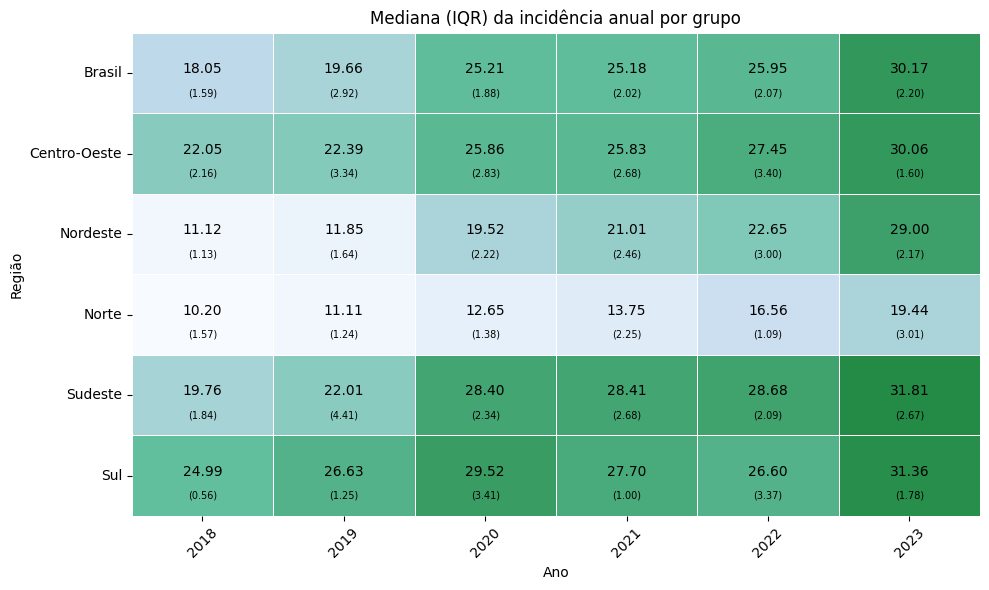

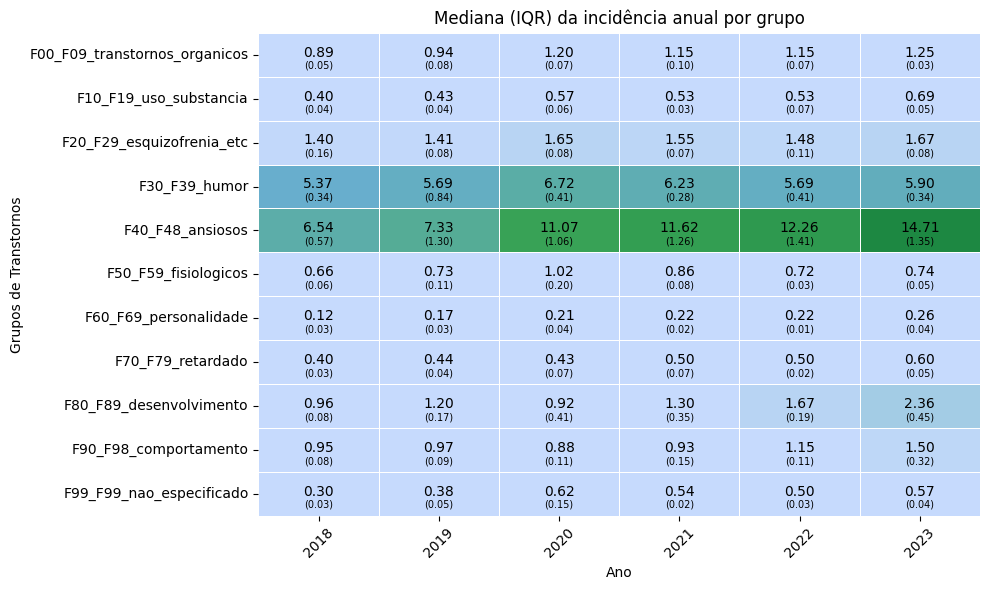

In [67]:
df_transtornos = RegressionDF[RegressionDF[GROUP_COL_NAME].str.match(r'^F\d')]
df_regioes = RegressionDF[~RegressionDF[GROUP_COL_NAME].str.match(r'^F\d')]

suave_azul_verde_intermediario = LinearSegmentedColormap.from_list(
    "SuaveAzulVerdeIntermediario",
    ["#c6dafd", "#9ecae1", "#6baed6", "#41ab5d", "#006d2c"]  # azul mais escuro → tons intermediários de azul → verde escuro
)

regiao_map = {'sul': "Sul",
              'centro_oeste' : 'Centro-Oeste',
              'nordeste' : 'Nordeste',
              'sudeste' : 'Sudeste',
              'norte' : "Norte"
              }
med_reg, iqr_reg = prepare_summary(df_regioes, GROUP_COL_NAME, RAW_ATD_VAR, RAW_TOTAL_ATD_VAR, series_name_map=regiao_map)
plot_heatmap_with_iqr(med_reg, iqr_reg, titulo="Mediana (IQR) da incidência anual por grupo", y_label="Região")


med_reg2, iqr_reg2 = prepare_summary(df_transtornos, GROUP_COL_NAME, RAW_ATD_VAR, RAW_TOTAL_ATD_VAR)
plot_heatmap_with_iqr(med_reg2, iqr_reg2, titulo="Mediana (IQR) da incidência anual por grupo",y_label="Grupos de Transtornos", clr_map=suave_azul_verde_intermediario,
                       norm = LogNorm(vmin=1.3, vmax=20))

#### TOTAL ===============================
#med_reg3, iqr_reg3 = prepare_summary(RegressionDF, GROUP_COL_NAME, RAW_ATD_VAR, RAW_TOTAL_ATD_VAR)
#plot_heatmap_with_iqr(med_reg3, iqr_reg3, titulo="Mediana e IQR da incidência anual por grupo",y_label="Grupos", clr_map=suave_azul_verde_intermediario,
#                       norm = LogNorm(vmin=2, vmax=40),
#                        figsize=(10, 10),
#                        iqr_font_size = 8,
#                        median_font_size = 10)
### ======================================

#median_df, iqr_df = prepare_summary_by_period(
#    df=RegressionDF,
#    group_col=GROUP_COL_NAME,  # Sua coluna de agrupamento
#    atd_var=RAW_ATD_VAR,
#    total_var=RAW_TOTAL_ATD_VAR,
#    #series_name_map={'Norte': 'Região Norte'}  # Opcional: renomear grupos
#)
#
## Plotar
#plot_period_heatmap_with_iqr(
#    median_df=median_df,
#    iqr_df=iqr_df,
#    titulo="Distribuição de Atendimentos em Saúde Mental por 1000 Consultas",
#    y_label="Regiões"
#)


In [68]:
summary = resumo_formato_mendeley(RegressionDF)
summary.to_excel('analise_descritiva.xlsx')


proporc_mediana = mediana_proporcao_anual_por_grupo(RegressionDF)
proporc_mediana.to_excel('serie_historica_proporcao_mediana.xlsx')




                               count           mean           std       min  \
regiao                                                                        
Brasil                          27.0  363812.814815  55680.654142  265309.0   
F00_F09_transtornos_organicos   27.0   17553.000000   2472.338989   12743.0   
F10_F19_uso_substancia          27.0    7988.851852   1202.417555    5880.0   
F20_F29_esquizofrenia_etc       27.0   26823.259259   3930.804357   20125.0   
F30_F39_humor                   27.0  106385.037037  14835.770018   81574.0   
F40_F48_ansiosos                27.0  136304.370370  22793.916471   96976.0   
F50_F59_fisiologicos            27.0   13083.888889   2069.644866    9350.0   
F60_F69_personalidade           27.0    2849.666667    619.610610    1787.0   
F70_F79_retardado               27.0    8014.370370   1220.449985    5914.0   
F80_F89_desenvolvimento         27.0   19783.666667   4634.247537   10815.0   
F90_F98_comportamento           27.0   18011.592593 

# Extrair

In [69]:
def extrair_resultados_its(results_dict, 
                           coef_names=None, 
                           add_exp=True, 
                           round_digits=6, 
                           formato='wide'):
    import pandas as pd
    import numpy as np

    if coef_names is None:
        coef_names = ['PreTrend', 'Pandemia_Step', 'Pandemia_Trend', 
                      'PosPandemia_Step', 'PosPandemia_Trend']
    
    rows = []

    for grupo, res in results_dict.items():
        for coef in coef_names:
            if coef in res.params:
                beta = res.params[coef]
                se   = res.bse[coef]
                pval = res.pvalues[coef]
                ci_low  = beta - 1.96 * se
                ci_high = beta + 1.96 * se
                if add_exp:
                    exp_beta = np.exp(beta)
                    exp_ci_low  = np.exp(ci_low)
                    exp_ci_high = np.exp(ci_high)
            else:
                beta = se = pval = ci_low = ci_high = np.nan
                exp_beta = exp_ci_low = exp_ci_high = np.nan

            if formato == 'long':
                row = {
                    'Regiao/Grupo': grupo,
                    'Coeficiente': coef,
                    'beta': round(beta, round_digits),
                    'se': round(se, round_digits),
                    'p': round(pval, 4),
                    'CI95_inf': round(ci_low, round_digits),
                    'CI95_sup': round(ci_high, round_digits),
                }
                if add_exp:
                    row['exp(beta)'] = round(exp_beta, round_digits)
                    row['exp(CI95_inf)'] = round(exp_ci_low, round_digits)
                    row['exp(CI95_sup)'] = round(exp_ci_high, round_digits)
                rows.append(row)
            else:
                base = {
                    f'{coef}_coef': round(beta, round_digits),
                    f'{coef}_se': round(se, round_digits),
                    f'{coef}_p': round(pval, 4),
                    f'{coef}_ci95_inf': round(ci_low, round_digits),
                    f'{coef}_ci95_sup': round(ci_high, round_digits)
                }
                if add_exp:
                    base[f'{coef}_exp'] = round(exp_beta, round_digits)
                    base[f'{coef}_exp_ci95_inf'] = round(exp_ci_low, round_digits)
                    base[f'{coef}_exp_ci95_sup'] = round(exp_ci_high, round_digits)
                row = {'Regiao/Grupo': grupo, **base} if not rows or rows[-1].get('Regiao/Grupo') != grupo else rows[-1].update(base)
                if not any(r.get('Regiao/Grupo') == grupo for r in rows):
                    rows.append(row)

    df = pd.DataFrame(rows)

    # Adiciona Pseudo R² apenas no formato wide
    if formato == 'wide':
        pseudo_r2 = []
        for grupo in df['Regiao/Grupo']:
            res = results_dict.get(grupo)
            r2 = getattr(res, 'prsquared', np.nan)
            pseudo_r2.append(round(r2, round_digits))
        df['Pseudo_R2'] = pseudo_r2

    return df


In [70]:
def extrair_tabela_formatada(results_dict, 
                              coef_map=None, 
                              round_digits=2):
    import pandas as pd
    import numpy as np

    if coef_map is None:
        coef_map = {
            #'Pandemia_Pulse': ('Pandemia', "Impacto inicial"),
            'Pandemia_Step': ('Pandemia', 'Mudança de nível'),
            'Pandemia_Trend': ('Pandemia', 'Mudança de tendência'),
            'PosPandemia_Step': ('Pós-pandemia', 'Mudança de nível'),
            'PosPandemia_Trend': ('Pós-pandemia', 'Mudança de tendência'),
        }

    linhas = []

    for grupo, res in results_dict.items():
        for coef, (periodo, efeito) in coef_map.items():
            if coef in res.params:
                beta = res.params[coef]
                se = res.bse[coef]
                pval = res.pvalues[coef]
                
                ci_low = np.exp(beta - 1.96 * se)
                ci_high = np.exp(beta + 1.96 * se)
                irr = np.exp(beta)
                
                p_str = "< 0.001" if pval < 0.001 else str(round(pval, 4))
            else:
                irr = ci_low = ci_high = np.nan
                p_str = ""

            linhas.append({
                'Região': grupo,
                'Efeito': efeito,
                'Período': periodo,
                'IRR': round(irr, round_digits) if not np.isnan(irr) else "",
                'IC95%': f"{round(ci_low, round_digits)} – {round(ci_high, round_digits)}" if not np.isnan(ci_low) else "",
                'p-valor': p_str
            })

    df = pd.DataFrame(linhas)

    # Reorganiza para formato com colunas multi-período
    df_pivot = df.pivot_table(index=['Região', 'Efeito'],
                              columns='Período',
                              values=['IRR', 'IC95%', 'p-valor'],
                              aggfunc='first')

    # Renomeia colunas para apresentação clara
    df_pivot.columns = [f"{periodo} {medida}" for medida, periodo in df_pivot.columns]
    df_pivot = df_pivot.reset_index()

    return df_pivot


In [71]:
formato_tabela = "long"
coef_names = ['Intercept','periodo', 'Pandemia_Step', 'Pandemia_Trend', 'PosPandemia_Step', 'PosPandemia_Trend']
tabela_its = extrair_resultados_its(results, 
    coef_names=coef_names,
    add_exp=True, round_digits=3, formato=formato_tabela)


#print(tabela_its.to_latex(index=False))
#tabela_its.to_excel(os.path.join(LOCAL_OUTPUT_PATH, 'diagnostics_results.xlsx'))
tabela_its.to_excel('Coefs.xlsx')


In [72]:
tabela_formatada = extrair_tabela_formatada(results)
tabela_formatada.to_excel('TabelaMudancasNivelETrend.xlsx')

# Diagnostico do Modelo

In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import chi2, shapiro
import seaborn as sns
import re

def test_model_diagnostics(results, dataframe, group_col, dependent_var, independent_var, output_dir='diagnostics_plots'):
    """
    Testa diagnósticos do modelo GLM e salva gráficos em uma pasta.
    
    Args:
        results: Dicionário com resultados dos modelos GLM
        dataframe: DataFrame com os dados originais
        group_col: Nome da coluna de agrupamento
        dependent_var: Nome da variável dependente
        independent_var: Nome da variável independente
        output_dir: Pasta para salvar os gráficos (default: 'diagnostics_plots')
    
    Returns:
        DataFrame com métricas de diagnóstico para cada modelo
    """
    # Criar diretório de saída se não existir
    os.makedirs(output_dir, exist_ok=True)
    
    diagnostics = {}

    for variable, result in results.items():
        # Filtrar os dados para a variável atual
        file_prefix = variable.split()[0] 
        variable_data = dataframe[dataframe[group_col] == variable].sort_values(by=DATE_NAME)
        y = variable_data[dependent_var].values
        X = variable_data[[independent_var]].values

        # 1. Testes estatísticos
        # Heterocedasticidade (Breusch-Pagan)
        bp_test = het_breuschpagan(result.resid_pearson, result.model.exog)
        bp_pvalue = bp_test[1]

        # Overdispersão (Teste Qui-Quadrado)
        pearson_chi2 = sum((result.resid_pearson) ** 2)
        overdispersion_pvalue = 1 - chi2.cdf(pearson_chi2, df=result.df_resid)

        # Autocorrelação
        dw_stat = durbin_watson(result.resid_deviance)
        ljungbox_test = acorr_ljungbox(result.resid_deviance, lags=[24], return_df=True)
        ljungbox_pvalue = ljungbox_test['lb_pvalue'].iloc[0]

        # Intervalos de confiança
        irrs = np.exp(result.params)
        conf_int = np.exp(result.conf_int())

        # Estatísticas descritivas dos resíduos
        resid_deviance = result.resid_deviance
        resid_stats = {
            'resid_dev_mean': np.mean(resid_deviance),
            'resid_dev_std': np.std(resid_deviance),
            'resid_dev_min': np.min(resid_deviance),
            'resid_dev_max': np.max(resid_deviance),
            'resid_dev_skew': stats.skew(resid_deviance),
            'resid_dev_kurtosis': stats.kurtosis(resid_deviance)
        }

        # Teste de normalidade Shapiro-Wilk
        shapiro_test = shapiro(resid_deviance)
        shapiro_pvalue = shapiro_test[1]

        # 2. Gerar e salvar gráficos
        # ACF Plot
        plt.figure()
        plot_acf(result.resid_deviance, lags=24)
        plt.title(f'ACF (Response Residuals Deviance): {variable}')
        plt.savefig(os.path.join(output_dir, f'acf_{file_prefix}.png'))
        plt.close()

        plt.figure()
        plot_pacf(result.resid_deviance, lags=24)
        plt.title(f'PACF (Response Residuals Deviance): {variable}')
        plt.savefig(os.path.join(output_dir, f'pacf_{file_prefix}.png'))
        plt.close()


        # Histograma de resíduos
        plt.figure(figsize=(10, 4))
        sns.histplot(resid_deviance, kde=True)
        plt.title(f"Distribuição dos Resíduos de Deviance: {file_prefix}")
        plt.xlabel("Resíduo")
        plt.ylabel("Frequência")
        plt.savefig(os.path.join(output_dir, f'hist_resid_{file_prefix}.png'))
        plt.close()

        # Resíduos vs Ajustados
        plt.figure(figsize=(10, 4))
        plt.scatter(result.fittedvalues, resid_deviance, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f"Resíduos de Deviance vs. Valores Ajustados: {variable}")
        plt.xlabel("Valores Ajustados")
        plt.ylabel("Resíduos")
        plt.savefig(os.path.join(output_dir, f'resid_vs_fitted_{file_prefix}.png'))
        plt.close()

        # Q-Q Plot
        plt.figure(figsize=(10, 4))
        qqplot(resid_deviance, line='s', alpha=0.5)
        plt.title(f"Q-Q Plot dos Resíduos: {variable}")
        plt.savefig(os.path.join(output_dir, f'qqplot_{file_prefix}.png'))
        plt.close()

        # 3. Armazenar todos os resultados
        diagnostics[variable] = {
            **resid_stats,
            "Heteroscedasticity (Breusch-Pagan p-value)": bp_pvalue,
            "Overdispersion (Pearson Chi2 p-value)": overdispersion_pvalue,
            "Autocorrelation (Durbin-Watson stat)": dw_stat,
            "Autocorrelation (Ljung-Box p-value)": ljungbox_pvalue,
            "Normality (Shapiro-Wilk p-value)": shapiro_pvalue,
            'IRR': irrs[0],
            "CI Lower": conf_int[0][0], 
            "CI Upper": conf_int[1][0],
            #'residuals_response': result.resid_response,
            #'residuals_pearson': result.resid_pearson,
            #'fittedvalues': result.fittedvalues
        }

    # Converter para DataFrame e transpor para ter variáveis como linhas
    df_results = pd.DataFrame(diagnostics).T
    
    # Salvar resultados em CSV
    df_results.to_excel(os.path.join(output_dir, 'diagnostics_results.xlsx'))
    
    return df_results

In [74]:
diagnostics_df = test_model_diagnostics(
    results=results,
    dataframe=RegressionDF,
    group_col=GROUP_COL_NAME,
    dependent_var=DEPENDENT_VAR,
    independent_var=INDEPENDENT_VAR
)

diagnostics_df


C:\Users\Lucas\AppData\Local\Temp\ipykernel_42956\435664273.py:122: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Lucas\AppData\Local\Temp\ipykernel_42956\435664273.py:123: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Lucas\AppData\Local\Temp\ipykernel_42956\435664273.py:124: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Lucas\AppData\Local\Temp\ipykernel_42956\435664273.py:122: FutureWarning:

Series.__g

,resid_dev_mean,resid_dev_std,resid_dev_min,resid_dev_max,resid_dev_skew,resid_dev_kurtosis,Heteroscedasticity (Breusch-Pagan p-value),Overdispersion (Pearson Chi2 p-value),Autocorrelation (Durbin-Watson stat),Autocorrelation (Ljung-Box p-value),Normality (Shapiro-Wilk p-value),IRR,CI Lower,CI Upper
sul,-0.019917,1.046232,-4.412896,2.005100,-0.733129,2.617968,0.012272,1.327178e-01,1.370839,6.501202e-03,0.003242,24.406116,23.045848,25.846673
sudeste,-0.018475,1.097032,-5.538635,2.385683,-1.571048,7.165770,0.128741,6.170814e-02,1.359393,4.559736e-06,0.000015,17.837633,17.389796,18.297003
norte,-0.030516,1.224216,-3.098677,4.818773,0.645055,2.723692,0.012428,2.090686e-04,0.983216,7.128151e-08,0.004064,9.110935,8.709421,9.530960
nordeste,-0.023235,1.151015,-2.802585,2.931915,0.002700,-0.006136,0.018487,6.671655e-03,1.021211,4.101651e-09,0.579700,9.624981,9.093668,10.187337
centro_oeste,-0.024007,1.032210,-4.551192,2.553697,-0.992089,4.072773,0.148448,1.978508e-01,1.318082,2.188662e-06,0.000622,20.089296,19.518002,20.677312
F99_F99_nao_especificado,-0.029872,1.109260,-2.119050,3.198692,0.510802,0.337319,0.000216,1.471366e-02,0.851854,5.188481e-26,0.164268,0.255644,0.237634,0.275020
F90_F98_comportamento,-0.026560,1.124211,-4.903140,2.372932,-1.212955,3.463014,0.086107,3.488789e-02,1.380737,3.307913e-09,0.000889,0.925063,0.869843,0.983788
F80_F89_desenvolvimento,-0.063598,1.635151,-5.788301,4.087585,-0.732317,1.351568,0.007518,2.908784e-13,0.882971,5.512204e-11,0.010159,0.854413,0.780022,0.935899
F70_F79_retardado,-0.024314,1.106024,-5.251973,3.146974,-0.961211,6.253881,0.095066,4.264779e-02,1.570295,1.653865e-01,0.000018,0.383272,0.373854,0.392927
F60_F69_personalidade,-0.018598,1.043065,-4.710355,2.161663,-1.315269,4.406748,0.241279,1.669537e-01,1.484567,2.428421e-01,0.000263,0.111968,0.106556,0.117655


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

# Define Hover Graph Func


In [75]:
def plot_with_all_dummies(
    variable: str,
    variable_df,
    results_obj,
    exclude_coeffs_by_prefix=None,
    plot_individual_effects=False,
    line_events=None, # Dict[str, Tuple[start, end, color, show_line]]
    slope_coef_str=None,
    real_serie_key=DEPENDENT_VAR,
    exponentite_coefs=False
):

    regression_stats = results_obj.params
    variable_df = variable_df.sort_values(by=DATE_NAME).reset_index(drop=True)
    dates = variable_df[DATE_NAME].values
    real_series = variable_df[real_serie_key].values

    slope_name = slope_coef_str if slope_coef_str else INDEPENDENT_VAR
    intercept = regression_stats.get("Intercept", 0)
    slope = regression_stats.get(slope_name, 0)
    t = np.arange(len(dates)) + 1


    #if exponentite_coefs:
        #slope = np.exp(slope) #if slope > 0 else slope
        #intercept = np.exp(intercept) if intercept > 0 else intercept
    baseline_log = (intercept + slope * t).astype(float)
    full_pred = baseline_log.copy()

    fig = go.Figure()

     #### Atendimentos sem taxa
    atd_raw = variable_df[RAW_ATD_VAR].values
    fig.add_trace(go.Bar(
        x=dates,
        y=atd_raw,
        name='Atendimentos',
        yaxis='y2',
        opacity = 0.4,
        marker_line=dict(color='black', width=0.5) 
    ))

    

    baseline = np.exp(baseline_log) if exponentite_coefs else baseline_log
    fig.add_trace(go.Scatter(
        x=dates,
        y=baseline,
        mode='lines',
        name='Baseline',
        line=dict(dash='dot', color='black')
    ))

    fig.add_trace(go.Scatter(
        x=dates,
        y=real_series,
        mode='markers',
        name='Real',
        marker=dict(color='black', size = 3)
    ))



    pand_effect = None
    pos_pand_effect = None
    for dummy_name, coef in regression_stats.items():
        if dummy_name in {"Intercept", INDEPENDENT_VAR}:
            continue
        if slope_coef_str and dummy_name == slope_coef_str:
            continue

        if exclude_coeffs_by_prefix and any(dummy_name.startswith(prefix) for prefix in exclude_coeffs_by_prefix):
            continue

        if dummy_name in variable_df.columns:
            dummy_ts = variable_df[dummy_name].values
            dummy_effect = coef * dummy_ts
            full_pred_copy = full_pred
            full_pred += dummy_effect

            #if dummy_name == "Pandemia_Step" or dummy_name == "Pandemia_Trend":
            #    if pand_effect is None:
            #        pand_effect = full_pred_copy + dummy_effect
            #    else:
            #        pand_effect += dummy_effect
#
            #if dummy_name == "PosPandemia_Step" or dummy_name == "PosPandemia_Trend":
            #    if pos_pand_effect is None:
            #        pos_pand_effect = full_pred_copy + dummy_effect
            #    else:
            #        pos_pand_effect += dummy_effect


            if plot_individual_effects:
                fig.add_trace(go.Scatter(
                    x=dates,
                    y=dummy_effect,
                    mode='lines',
                    name=f'Effect: {dummy_name}',
                    line=dict(dash='dash')
                ))


    if line_events:
        for line_dummy_name, (event_start_date, event_end_date, fillcolor, show_line) in line_events.items():
            if fillcolor:
                # Sombra para eventos tipo "pulse"
                fig.add_shape(
                    type="rect",
                    x0=event_start_date,
                    x1=event_end_date,
                    y0=0,
                    y1=1,
                    xref="x",
                    yref="paper",
                    fillcolor=fillcolor,
                    opacity=0.3,
                    layer="below",
                    line_width=0,
                )

            if show_line:
                # Linha e anotação para eventos como Pandemia e Pós-Pandemia
                fig.add_shape(
                    type="line",
                    x0=event_start_date,
                    x1=event_start_date,
                    y0=min(real_series),
                    y1=max(real_series),
                    line=dict(color="black", dash="dash")
                )

                # Anotação deslocada no eixo x
                fig.add_annotation(
                    x=event_start_date,
                    y=max(real_series),
                    text=f"{line_dummy_name}",
                    showarrow=True,
                    arrowhead=2,
                    ax=30,  # deslocamento lateral
                    ay=-40
                )




    
    
    full_pred = np.exp(full_pred) if exponentite_coefs else full_pred
    
    #pand_efect = np.exp(pand_effect) if exponentite_coefs else pand_effect
    #pos_pand_effect = np.exp(pos_pand_effect) if exponentite_coefs else pos_pand_effect
    #fig.add_trace(go.Scatter(
    #    x=dates,
    #    y=pand_efect,
    #    mode='lines',
    #    name='Full model',
    #    line=dict(color='red')
    #))
##
    #fig.add_trace(go.Scatter(
    #    x=dates,
    #    y=pos_pand_effect,
    #    mode='lines',
    #    name='Full model',
    #    line=dict(color='blue')
    #))

    fig.add_trace(go.Scatter(
        x=dates,
        y=full_pred,
        mode='lines',
        name='Full model',
        line=dict(color='purple')
    ))

    ############################ Sombreamento
    ## Cores e nomes para cada cenário
    #fill_pos = 'rgba(50, 200, 50, 0.3)'  # Verde (positivo)
    #fill_neg = 'rgba(200, 50, 50, 0.3)'  # Vermelho (negativo)
#
    ## Máscaras para valores positivos e negativos
    #mask_pos = full_pred > baseline
    #mask_neg = full_pred < baseline
#
    ## Linha base invisível (referência)
    #fig.add_trace(go.Scatter(
    #    x=dates,
    #    y=baseline,
    #    mode='lines',
    #    line=dict(width=0),
    #    showlegend=False,
    #    hoverinfo='skip'
    #))
#
    ## Sombreamento para EFEITO POSITIVO (full_pred >= baseline)
    #fig.add_trace(go.Scatter(
    #    x=dates[mask_pos],
    #    y=full_pred[mask_pos],
    #    mode='lines',
    #    fill='tonexty',
    #    fillcolor=fill_pos,
    #    name='Efeito Positivo',
    #    line=dict(width=0),  # Linha invisível
    #    hoverinfo='skip'
    #))
#
    #fig.add_trace(go.Scatter(
    #    x=dates,
    #    y=baseline,
    #    mode='lines',
    #    line=dict(width=0),
    #    showlegend=False,
    #    hoverinfo='skip'
    #))
    ## Sombreamento para EFEITO NEGATIVO (full_pred < baseline)
    #fig.add_trace(go.Scatter(
    #    x=dates[mask_neg],
    #    y=full_pred[mask_neg],
    #    mode='lines',
    #    fill='tonexty',
    #    fillcolor=fill_neg,
    #    name='Efeito Negativo',
    #    line=dict(width=0),  # Linha invisível
    #    hoverinfo='skip'
    #))

    ############################################
    max_val = max(atd_raw)
    min_val = min(atd_raw)
    fig.update_layout(
        yaxis=dict(
            title="Taxa por 1.000",
            side='left'
        ),
        yaxis2=dict(
            range = [min_val, max_val*2.5],
            title="Atendimentos",
            overlaying='y',
            side='right',
            showgrid=False
        )
    )

    fig.update_layout(
        title=variable,
        xaxis_title="Tempo",
        yaxis_title="Taxa de Incidência (por 1000 atendimentos)",
        legend_title="Legend",
    )
    
    fig.show()


# Define Forest Plot for coeffs

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def extrair_coef_ci(result_obj, var_names, alpha=0.05):
    """
    Extrai coeficientes e intervalos de confiança de um modelo GLM.
    Retorna DataFrame com: variável, coef, IC95_inf, IC95_sup, exp(coef), exp(IC)
    """
    coefs = result_obj.params[var_names]
    conf_int = result_obj.conf_int(alpha=alpha).loc[var_names]
    
    df = pd.DataFrame({
        'variavel': var_names,
        'coef': coefs.values,
        'IC_inf': conf_int[0].values,
        'IC_sup': conf_int[1].values
    })
    df['exp(coef)'] = np.exp(df['coef'])
    df['exp(IC_inf)'] = np.exp(df['IC_inf'])
    df['exp(IC_sup)'] = np.exp(df['IC_sup'])
    return df

def compilar_dados_para_forest(region_results, pandemic_vars):
    """
    Compila dados de todas as regiões para as variáveis de interesse.
    Retorna DataFrame longo com colunas: região, variável, coef, ICs, exp(...)
    """
    frames = []
    for regiao, result in region_results.items():
        df = extrair_coef_ci(result, pandemic_vars)
        df['regiao'] = regiao
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

def plot_forest(data, tipo='step', escala_log=False, figsize=(10, 6)):
    """
    Plota forest plot para tipo específico ('step' ou 'trend') com barras de erro alinhadas corretamente.
    """
    assert tipo in ['step', 'trend'], "Tipo deve ser 'step' ou 'trend'"
    
    if tipo == 'step':
        data_plot = data[data['variavel'].str.contains('Step')].copy()
        titulo = "Efeitos Step: Mudança Imediata"
    else:
        data_plot = data[data['variavel'].str.contains('Trend')].copy()
        titulo = "Efeitos Trend: Mudança de Tendência"

    # Ordenar para visual consistente
    data_plot['regiao'] = pd.Categorical(data_plot['regiao'], categories=sorted(data_plot['regiao'].unique()), ordered=True)
    data_plot = data_plot.sort_values(by=['regiao', 'variavel'], ascending=[True, True])

    plt.figure(figsize=figsize)
    sns.set(style="whitegrid")

    ax = sns.pointplot(
        data=data_plot,
        y='regiao',
        x='exp(coef)',
        hue='variavel',
        dodge=0.6,
        join=False,
        ci=None
    )

    # Obtem as posições reais das marcas no eixo Y (para alinhar os erros)
    offsets = {}
    regiao_labels = data_plot['regiao'].cat.categories.tolist()
    for i, regiao in enumerate(regiao_labels):
        variaveis_na_regiao = data_plot[data_plot['regiao'] == regiao]['variavel'].tolist()
        for j, var in enumerate(variaveis_na_regiao):
            offsets[(regiao, var)] = i + (j - len(variaveis_na_regiao)/2) * 0.25  # espaçamento manual

    # Adiciona barras de erro corrigidas
    for _, row in data_plot.iterrows():
        y_pos = offsets[(row['regiao'], row['variavel'])]
        ax.errorbar(
            x=row['exp(coef)'],
            y=y_pos,
            xerr=[[row['exp(coef)'] - row['exp(IC_inf)']], [row['exp(IC_sup)'] - row['exp(coef)']]],
            fmt='none',
            ecolor='gray',
            capsize=4,
            linewidth=1
        )

    if escala_log:
        ax.set_xscale('log')
        ax.axvline(1, linestyle='--', color='black')
    else:
        ax.axvline(1, linestyle='--', color='black')

    ax.set_title(titulo)
    ax.set_xlabel('Razão de taxas (exp(coef))')
    ax.set_ylabel('Região')
    plt.legend(title='Variável', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_forest_barras(data, tipo='step', escala_log=False, figsize=(10, 6), capsize=0.05):
    """
    Plota forest plot com barras horizontais coloridas e 'caps' nas pontas.
    """
    assert tipo in ['step', 'trend'], "Tipo deve ser 'step' ou 'trend'"

    if tipo == 'step':
        data_plot = data[data['variavel'].str.contains('Step')].copy()
        titulo = "Efeitos Step: Mudança Imediata"
    else:
        data_plot = data[data['variavel'].str.contains('Trend')].copy()
        titulo = "Efeitos Trend: Mudança de Tendência"

    data_plot['regiao'] = pd.Categorical(data_plot['regiao'], categories=sorted(data_plot['regiao'].unique()), ordered=True)
    data_plot = data_plot.sort_values(by=['regiao', 'variavel'])

    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style="whitegrid")

    # Paleta de cores por variável
    cores = sns.color_palette("Set2", len(data_plot['variavel'].unique()))
    cor_map = dict(zip(data_plot['variavel'].unique(), cores))

    # Calcular posições Y com deslocamento
    regiao_labels = data_plot['regiao'].cat.categories.tolist()
    n_variaveis = data_plot['variavel'].nunique()
    altura = 0.15  # controle de espessura da barra
    deslocamento_total = (n_variaveis - 1) * altura / 2

    posicoes = {}
    for i, regiao in enumerate(regiao_labels):
        vars_regiao = data_plot[data_plot['regiao'] == regiao]['variavel'].tolist()
        for j, var in enumerate(vars_regiao):
            posicoes[(regiao, var)] = i - deslocamento_total + j * altura

    # Plotar linhas + caps
    for _, row in data_plot.iterrows():
        y = posicoes[(row['regiao'], row['variavel'])]
        cor = cor_map[row['variavel']]
        x0, x1 = row['exp(IC_inf)'], row['exp(IC_sup)']
        ax.hlines(y=y, xmin=x0, xmax=x1, color=cor, linewidth=3)
        cap_len = capsize * (x1 if escala_log else 1)  # ajusta escala do cap
        ax.plot([x0, x0], [y - altura/2, y + altura/2], color=cor, linewidth=1)  # cap esquerda
        ax.plot([x1, x1], [y - altura/2, y + altura/2], color=cor, linewidth=1)  # cap direita

    # Eixo log?
    if escala_log:
        ax.set_xscale('log')
        ax.axvline(1, linestyle='--', color='black')
    else:
        ax.axvline(1, linestyle='--', color='black')

    ax.set_yticks(range(len(regiao_labels)))
    ax.set_yticklabels(regiao_labels)
    ax.set_xlabel('Razão de taxas (exp(coef))')
    ax.set_title(titulo)

    # Legenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(color=cor_map[v], label=v) for v in cor_map]
    ax.legend(handles=legend_elements, title="Variável", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()



In [77]:
def plot_forest_painel(data, escala_log=False, figsize=(14, 7), capsize=0.05):
    """
    Painel com dois forest plots lado a lado: Step e Trend.
    """
    tipos = ['step', 'trend']
    titulos = ["Efeitos Step: Mudança Imediata", "Efeitos Trend: Mudança de Tendência"]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    sns.set(style="whitegrid")

    cores = sns.color_palette("Set2", len(data['variavel'].unique()))
    var_names = sorted(data['variavel'].unique())
    cor_map = dict(zip(var_names, cores))

    regiao_labels = sorted(data['regiao'].unique())
    n_variaveis = sum(["Step" in v for v in var_names])  # assume mesmo número para Trend
    altura = 0.15
    deslocamento_total = (n_variaveis - 1) * altura / 2

    # Posição Y para cada (região, variável)
    posicoes = {}
    # Construir as posições verticais para cada (região, base_var)
    for i, regiao in enumerate(regiao_labels):
        vars_regiao = sorted(data[data['regiao'] == regiao]['variavel'].unique())
        vars_escolhidas = [v for v in vars_regiao if "Step" in v]  # base comum
        for j, var in enumerate(vars_escolhidas):
            base_var = var.replace("Step", "").replace("Trend", "")
            pos_y = i * n_variaveis + j * altura - deslocamento_total
            posicoes[(regiao, base_var)] = pos_y

    ytick_pos = []
    ytick_labels = []

    for i, regiao in enumerate(regiao_labels):
        vars_regiao = sorted(data[data['regiao'] == regiao]['variavel'].unique())
        vars_escolhidas = [v for v in vars_regiao if "Step" in v]
        ys = []
        for var in vars_escolhidas:
            base_var = var.replace("Step", "").replace("Trend", "")
            ys.append(posicoes[(regiao, base_var)])
        media_y = sum(ys) / len(ys)
        ytick_pos.append(media_y)
        ytick_labels.append(regiao)

    for ax, tipo, titulo in zip(axes, tipos, titulos):
        if tipo == 'step':
            dplot = data[data['variavel'].str.contains('Step')].copy()
        else:
            dplot = data[data['variavel'].str.contains('Trend')].copy()

        dplot = dplot.sort_values(by=['regiao', 'variavel'])

        for _, row in dplot.iterrows():
            base_var = row['variavel'].replace("Step", "").replace("Trend", "")
            y = posicoes[(row['regiao'], base_var)]
            cor = cor_map[row['variavel']]
            x0, x1 = row['exp(IC_inf)'], row['exp(IC_sup)']
            ax.hlines(y=y, xmin=x0, xmax=x1, color=cor, linewidth=3)
            ax.plot([x0, x0], [y - altura/2, y + altura/2], color=cor, linewidth=1)
            ax.plot([x1, x1], [y - altura/2, y + altura/2], color=cor, linewidth=1)

        if escala_log:
            ax.set_xscale('log')
            ax.axvline(1, linestyle='--', color='black')
        else:
            ax.axvline(1, linestyle='--', color='black')

        ax.set_title(titulo)
        ax.set_xlabel("Razão de taxas (exp(coef))")

    axes[0].set_yticks(range(len(regiao_labels)))
    axes[0].set_yticklabels(regiao_labels)
    #axes[0].set_yticks(ytick_pos)
    #axes[0].set_yticklabels(ytick_labels)
    axes[1].set_yticks([])  # limpa eixo y da direita

    # Legenda única
    from matplotlib.patches import Patch
    legend_elements = [Patch(color=cor_map[v], label=v) for v in sorted(cor_map)]
    axes[1].legend(handles=legend_elements, title="Variável", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [78]:
## Define as variáveis
#pandemic_vars = ['Pandemia_Step', 'Pandemia_Trend', 'PosPandemia_Step', 'PosPandemia_Trend']
#
## Garante que region_keys não tenha duplicatas
#region_keys = list(set(['Brasil', 'norte', 'sul', 'centro_oeste', 'nordeste', 'sudeste']))
#
## Filtra os resultados
#region_results = {k: v for k, v in results.items() if k in region_keys}
#
## Compila dados
#df_forest = compilar_dados_para_forest(region_results, pandemic_vars)
#
## Plota Step e Trend
#plot_forest_painel(df_forest, escala_log = False)
##plot_forest_barras(df_forest, tipo='step', escala_log=False)
##plot_forest_barras(df_forest, tipo='trend', escala_log=False)

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_errorbars_flipped(region_results, 
                      pandemic_vars=None,
                      region_names=None,
                      x_label='Coefficient Estimate',
                      y_label='Region',
                      title='Pandemic Effects by Variable\nwith HAC Confidence Intervals',
                      figsize=(12, 8),
                      palette='colorblind',
                      ci_alpha=0.8,
                      zero_line=True,
                      legend_title='Variable',
                      variable_labels=None,
                      sort_regions=True,
                      **kwargs):
    """
    Plota barras de erro por região, agrupadas por variável (inversão de eixos).
    """
    plt.figure(figsize=figsize)
    
    all_coefs = []
    for region, res in region_results.items():

        coefs = res.params.to_frame(name='estimate')
        coefs['region'] = region_names.get(region, region) if region_names else region
        ci = res.conf_int()
        print("-------", region)
        print(ci)
        coefs['ci_lower'] = ci.iloc[:, 0]
        coefs['ci_upper'] = ci.iloc[:, 1]
        all_coefs.append(coefs)

    df = pd.concat(all_coefs).reset_index().rename(columns={'index': 'variable'})

    if pandemic_vars is None:
        pandemic_vars = ['pandemia_dummy', 'pos_pandemia_step']
    df = df[df['variable'].isin(pandemic_vars)]

    if sort_regions:
        df = df.sort_values('region')

    regions = df['region'].unique()
    variables = df['variable'].unique()

    n_vars = len(variables)
    palette_colors = sns.color_palette("husl", n_colors=8) #sns.color_palette(palette, n_vars)

    for i, var in enumerate(variables):
        var_data = df[df['variable'] == var]
        y_pos = np.arange(len(var_data['region']))
        offset = (i - n_vars/2 + 0.5) * 0.4

        plt.errorbar(
            x=var_data['estimate'],
            y=y_pos + offset,
            xerr=[var_data['estimate'] - var_data['ci_lower'], 
                  var_data['ci_upper'] - var_data['estimate']],
            fmt='none',
            ecolor=palette_colors[i],
            elinewidth=1,
            capsize=8,
            capthick=2,
            alpha=ci_alpha,
            label=variable_labels.get(var, var) if variable_labels else var
        )

    if zero_line:
        plt.axvline(0, color='gray', linestyle='--', alpha=0.7)

    plt.yticks(np.arange(len(regions)), regions)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return plt.gca()


In [80]:
#region_keys = ['Brasil', 'norte', 'sul', 'centro_oeste', 'norte', 'nordeste', 'sudeste']
#
#region_results = {k: v for k, v in results.items() if k in region_keys}
############## REVISAR!
#plot_errorbars_flipped(
#    region_results,
#    pandemic_vars=['Pandemia_Step', 'Pandemia_Trend', 'PosPandemia_Step', 'PosPandemia_Trend'], #DUMMY_NAMES,
#    title='Mental Health Visit Rate Changes During Pandemic',
#    x_label='Change in Visits per 1000',
#    palette='dark',
#    #variable_labels={
#    #    'pandemia_dummy': 'Pandemic Onset',
#    #    'pos_pandemia_step': 'Post-Pandemic Level Change',
#    #    'pos_pandemia_trend': 'Post-Pandemic Trend Change'
#    #},
#    figsize=(10, 8)
#)



In [81]:
#transtornos_results = {k: v for k, v in results.items() if not k in region_keys}
#plot_errorbars_flipped(
#    transtornos_results,
#    pandemic_vars=['Pandemia_Step', 'Pandemia_Trend', 'PosPandemia_Step', 'PosPandemia_Trend'], #DUMMY_NAMES,
#
#    title='Mental Health Visit Rate Changes During Pandemic',
#    x_label='Change in Visits per 1000',
#    palette='muted',
#    variable_labels={
#        'pandemia_dummy': 'Pandemic Onset',
#        'pos_pandemia_step': 'Post-Pandemic Level Change',
#        'pos_pandemia_trend': 'Post-Pandemic Trend Change'
#    },
#    figsize=(10, 6)
#)

# EXEC --- Plot Graph

In [82]:
for variable in results:
    variable_result = results[variable]
    variable_df = RegressionDF[RegressionDF[GROUP_COL_NAME] == variable]
    plot_with_all_dummies(variable,
                            variable_df,
                            variable_result,
                            exclude_coeffs_by_prefix=[
                                "month_",
                                'quarter_',
                                'sin','cos'
                                ],
                            line_events = {
                                #'Choque_Inicial':        [CHOQUE_INICIAL_START_DATE, CHOQUE_INICIAL_END_DATE, "rgba(0, 0, 0, 0.25)", False],
                                #'Lockdown_2021':         [SECONDLOCKDOWN_START_DATE, SECONDLOCKDOWN_END_DATE, "rgba(0, 0, 0, 0.25)", False],
                                'Pandemia':         [PANDEMIA_START_DATE, PANDEMIA_END_DATE, None, True],
                                'Pos Pandemia':      [POS_PANDEMIA_START_DATE, END_DATE, None, True]
                            },
                            real_serie_key=IR_VAR,
                            exponentite_coefs=MODEL_DEF == "GEE" or MODEL_DEF == "GLM",
                            plot_individual_effects=False
                            #slope_coef_str='PrePandemia_Trend'
                            )
